# (30) Fit -- cuda0

**Motivation**: Fitting notebook, cuda0 <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from model.train_vae import TrainerVAE, ConfigTrain
from model.vae2d import VAE, ConfigVAE
from analysis.opticflow import *
from figures.fighelper import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
# from torch import _dynamo
# _dynamo.config.cache_size_limit = 1024

## Trainer

In [2]:
vae = VAE(ConfigVAE(
    n_latent_scales=2, n_groups_per_scale=20, n_latent_per_group=7,
    scale_init=False, residual_kl=True, ada_groups=True,
))
tr = TrainerVAE(
    # model=torch.compile(vae),
    model=vae,
    cfg=ConfigTrain(
        lr=0.01, batch_size=512, epochs=2000, grad_clip=1000,
        lambda_anneal=True, lambda_init=1e-5, lambda_norm=1e-2,
        kl_beta=0.25, kl_anneal_cycles=1,
        scheduler_kws={'T_max': 660.0, 'eta_min': 1e-05}),
    device='cuda:0',
)
vae.cfg.total_latents()

210

In [3]:
vae.print()
vae.scales

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|     VAE     |  17.0 Mil  |
|     ---     |    ---     |
|     stem    |   1.1 K    |
|     pre     |   96.0 K   |
|  enc_tower  |  9.4 Mil   |
|     enc0    |   16.6 K   |
| enc_sampler |  1.4 Mil   |
| dec_sampler |  1.4 Mil   |
|    expand   |   71.0 K   |
|  dec_tower  |  4.5 Mil   |
|     post    |   40.0 K   |
|     out     |    578     |
+-------------+------------+

[8, 4]

In [4]:
len(vae.all_conv_layers), len(vae.all_log_norm)

(291, 228)

## Review train options

In [5]:
print(f"{vae.cfg.name()}\n{tr.cfg.name()}")

k-32_z-7x[10,20]_enc(2x2)-dec(2x1)-pre(1x3)-post(1x3)
ep2000-b512-lr(0.01)_beta(0.25)-anneal(1x0.3)_lambda(0.01)_grad(1000)

## Train

In [6]:
comment = f"ClipVal:500_{tr.cfg.name()}"
tr.train(comment=comment)

epoch # 1125, avg loss: nan:  56%|█████▌    | 1124/2000 [20:38:36<16:05:19, 66.12s/it]                 


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [7]:
%%time

val, loss = tr.validate(use_ema=False)
val_ema, loss_ema = tr.validate(use_ema=True)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [8]:
loss_summary = {
    k: {
        'vae': np.round(v.mean(), 2),
        'ema': np.round(loss_ema[k].mean(), 2),
    } for k, v in loss.items()
}
print(loss_summary)

NameError: name 'loss' is not defined

In [ ]:
for k, v in val.items():
    if 'fig' in k:
        print(f"{k} (VAE)")
        display(v)
        print(f"{k} (EMA)")
        display(val_ema[k])
        print('-' * 70)

In [46]:
from sklearn.feature_selection import mutual_info_regression
x = np.random.randn(10000, 210)
y = np.random.randn(10000, 11)
y[:, 0] = np.tanh(x[:, 0])

In [47]:
%%time

for i in range(11):
    mi = mutual_info_regression(x, y[:, i])

CPU times: user 1min 59s, sys: 168 ms, total: 1min 59s
Wall time: 1min 59s


In [ ]:
%%time

with joblib.parallel_backend('multiprocessing'):
    mi = joblib.Parallel(n_jobs=1)(
        joblib.delayed(mutual_info_regression)
        (x, y[:, i]) for i in range(11)
    )
mi = np.stack(mi)

In [ ]:
%%time

with joblib.parallel_backend('multiprocessing'):
    mi = joblib.Parallel(n_jobs=-1)(
        joblib.delayed(mutual_info_regression)
        (x, y[:, i]) for i in range(11)
    )
mi = np.stack(mi)

## Gradient quantiles

In [12]:
a = np.stack(tr.stats['q'])
a.shape

(3028, 4)

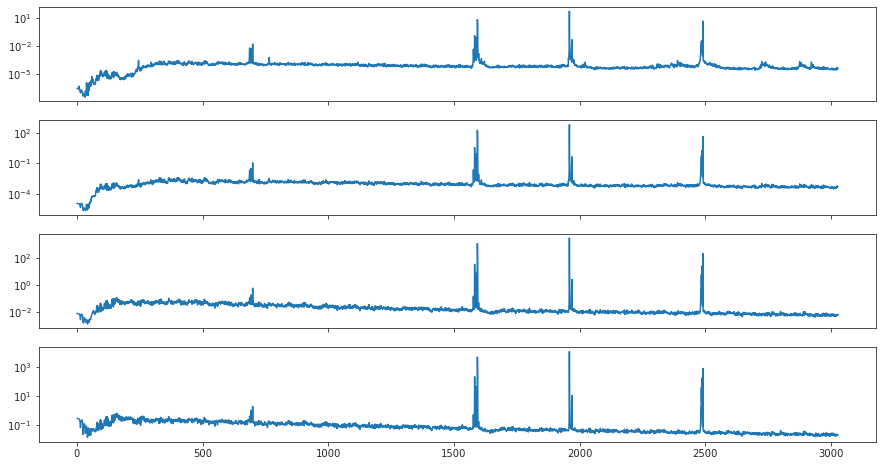

In [21]:
fig, axes = create_figure(4, 1, (15, 8), 'all')
for i, ax in enumerate(axes.flat):
    ax.plot(a[:, i])
    ax.set_yscale('log')

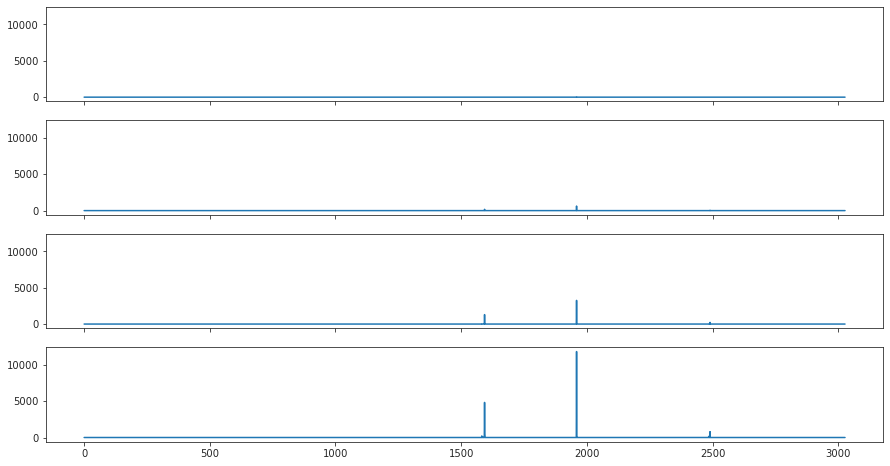

In [23]:
fig, axes = create_figure(4, 1, (15, 8), 'all', 'all')
for i, ax in enumerate(axes.flat):
    ax.plot(a[:, i])
    # ax.set_yscale('log')

In [27]:
ids = np.argsort(a[:, 3])[::-1]

In [29]:
a[ids][:10]

array([[4.70497303e+01, 6.24381454e+02, 3.25176420e+03, 1.18062537e+04],
       [6.09734440e+00, 1.76353558e+02, 1.29898698e+03, 4.81890981e+03],
       [4.28144193e+00, 4.32554083e+01, 2.24989483e+02, 8.07263673e+02],
       [2.16084993e+00, 1.57247159e+01, 9.92054600e+01, 4.63432818e+02],
       [1.19143877e-01, 3.40490681e+00, 3.50532925e+01, 2.12924517e+02],
       [3.73780169e-02, 1.79290777e+00, 2.68807427e+01, 1.75726674e+02],
       [7.94552900e-02, 8.66108224e-01, 7.59450638e+00, 4.32092611e+01],
       [2.84448471e-02, 5.04085064e-01, 5.93678675e+00, 3.94013906e+01],
       [3.92370038e-02, 2.42084436e-01, 1.97695330e+00, 1.15657066e+01],
       [4.41845823e-02, 4.34113048e-01, 2.57850293e+00, 1.09694010e+01]])

## Eval fit

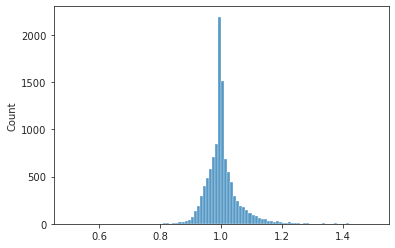

In [9]:
all_norm = [torch.exp(n.ravel()) for n in vae.all_log_norm]
all_norm = to_np(torch.cat(all_norm))
sns.histplot(all_norm, bins=np.linspace(0.5, 1.5, 101));

In [10]:
np.max(all_norm), 100 * (all_norm < 0.5).sum() / len(all_norm), 100 * (all_norm > 1.5).sum() / len(all_norm)

(2.0224917, 0.0, 0.2085600290170475)

In [11]:
%%time

val, loss = tr.validate(use_ema=False)
val_ema, loss_ema = tr.validate(use_ema=True)

CPU times: user 3min 33s, sys: 2.36 s, total: 3min 35s
Wall time: 3min 27s


In [12]:
loss_summary = {
    k: {
        'vae': np.round(v.mean(), 2),
        'ema': np.round(loss_ema[k].mean(), 2),
    } for k, v in loss.items()
}
print(loss_summary)

{
    'kl': {'vae': 41.56, 'ema': 41.44},
    'epe': {'vae': 2.54, 'ema': 2.52},
    'cos': {'vae': 3.62, 'ema': 3.59},
    'l1': {'vae': 0.89, 'ema': 0.88},
    'l2': {'vae': 0.41, 'ema': 0.4}
}

fig/sample (VAE)

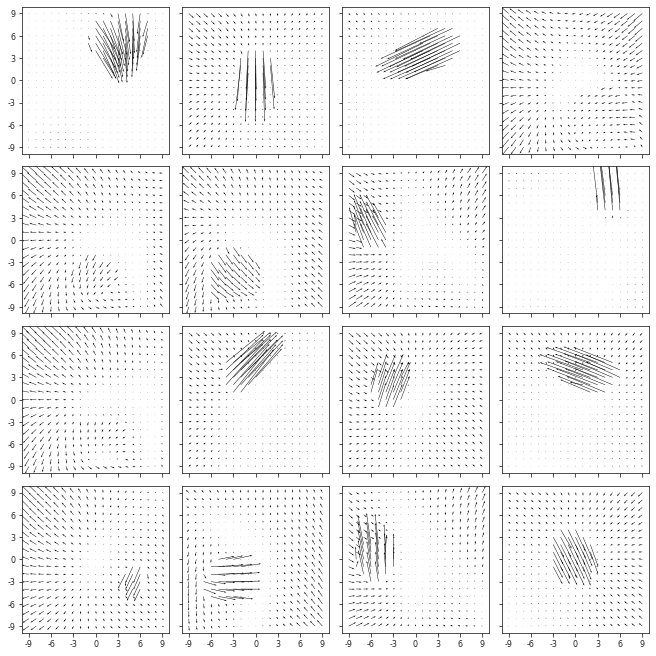

fig/sample (EMA)

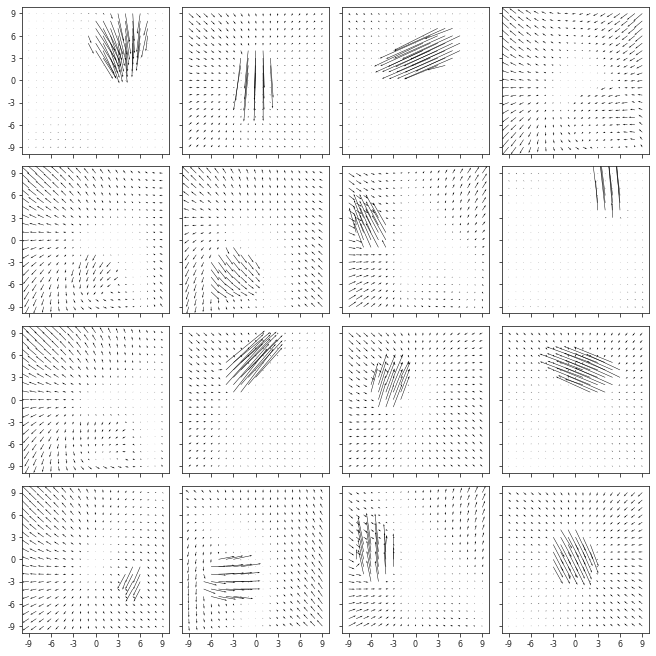

----------------------------------------------------------------------

fig/regression (VAE)

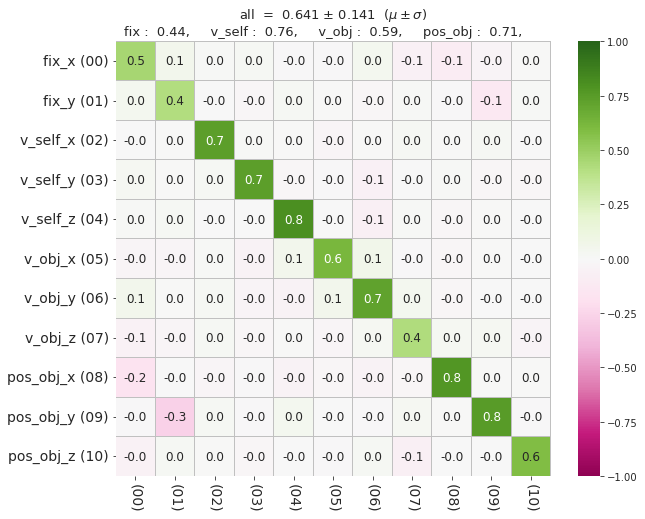

fig/regression (EMA)

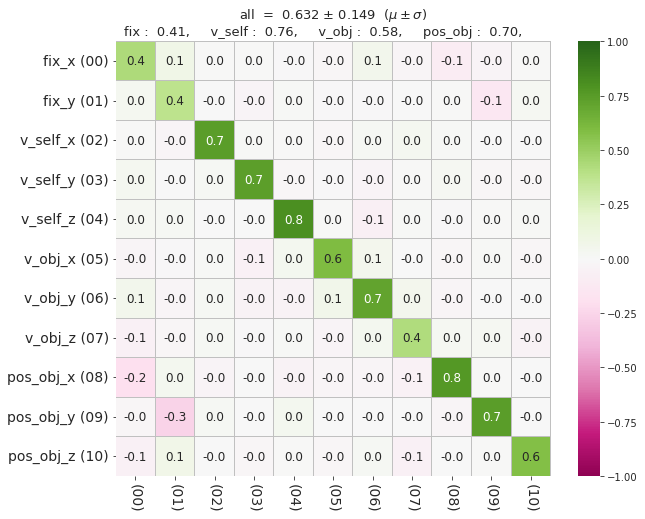

----------------------------------------------------------------------

fig/mutual_info (VAE)

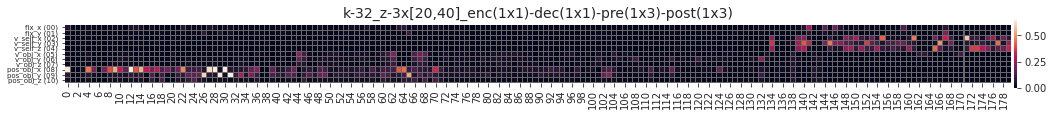

fig/mutual_info (EMA)

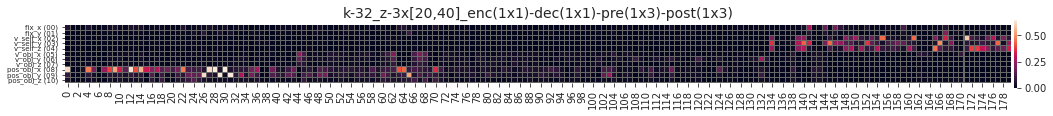

----------------------------------------------------------------------

In [13]:
for k, v in val.items():
    if 'fig' in k:
        print(f"{k} (VAE)")
        display(v)
        print(f"{k} (EMA)")
        display(val_ema[k])
        print('-' * 70)

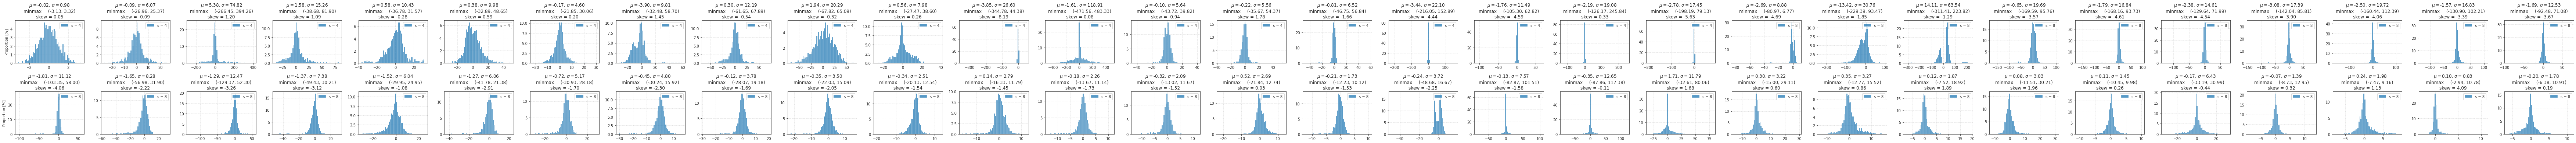

In [14]:
_ = plot_latents_hist(
    z=val['z_sample'],
    scales=vae.latent_scales()[0],
)

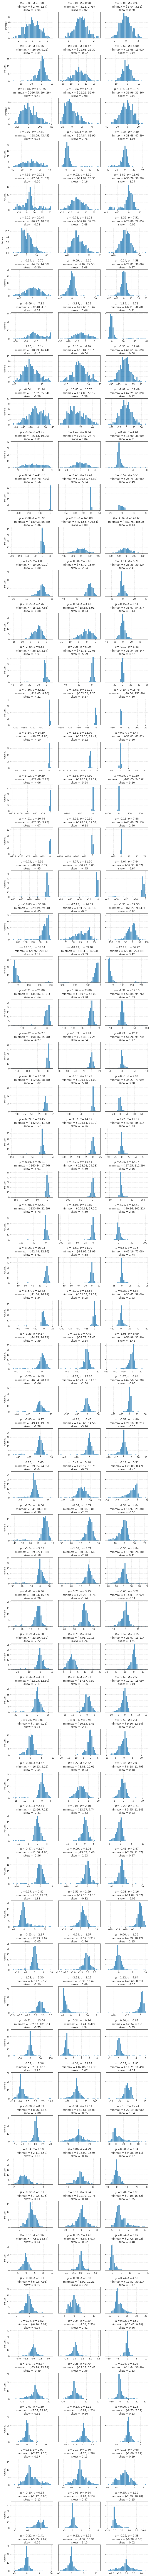

CPU times: user 33.7 s, sys: 844 ms, total: 34.5 s
Wall time: 34.5 s


In [15]:
%%time

_ = plot_latents_hist_full(
    z=val['z_sample'],
    scales=vae.latent_scales()[0],
    constrained_layout=False,
    tight_layout=True,
)

In [15]:
val, loss = tr.validate(n_samples=4096)
{k: v.mean() for k, v in loss.items()}

{'kl': 38.709934,
 'l1': 0.77352965,
 'l2': 0.3276513,
 'epe': 2.669891,
 'cos': 5.8701677}

In [16]:
print(f"{vae.cfg.name()}\n{tr.cfg.name()}")

k-32_z-5x[10,20]_cells-2_pre-1x3_post-1x3
ep1000-b512-lr(0.001)_beta(0.25)-anneal(0x0.3)_lambda(0.01)_grad(1000)_bal-equal

fig/sample

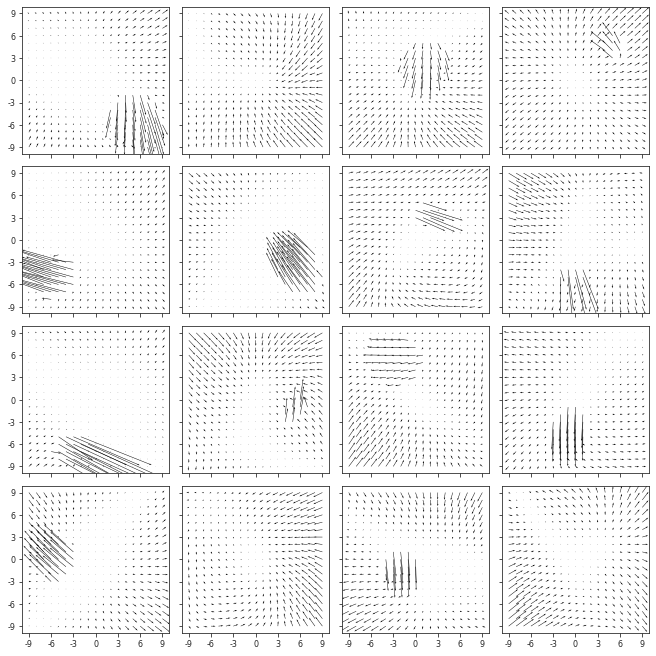

fig/corr_z

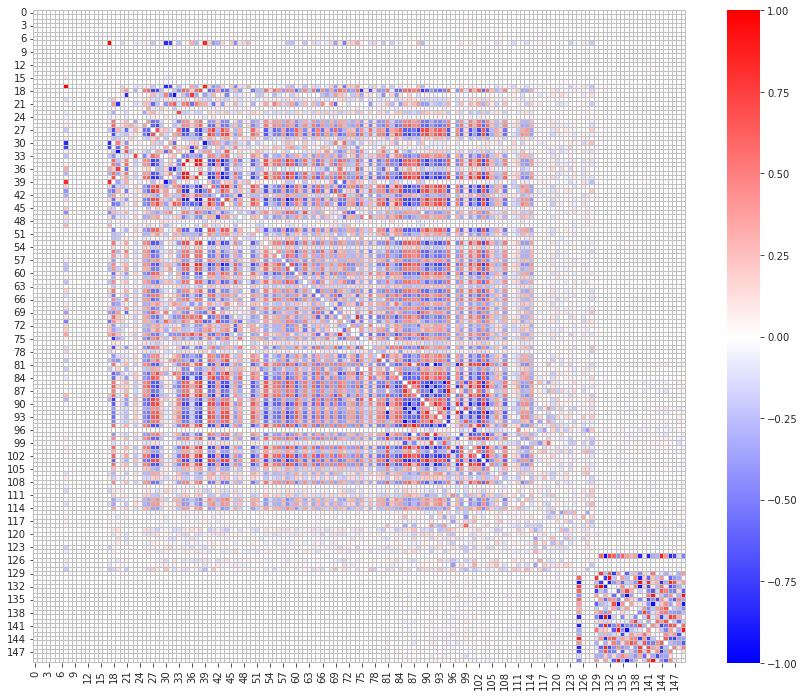

fig/regression

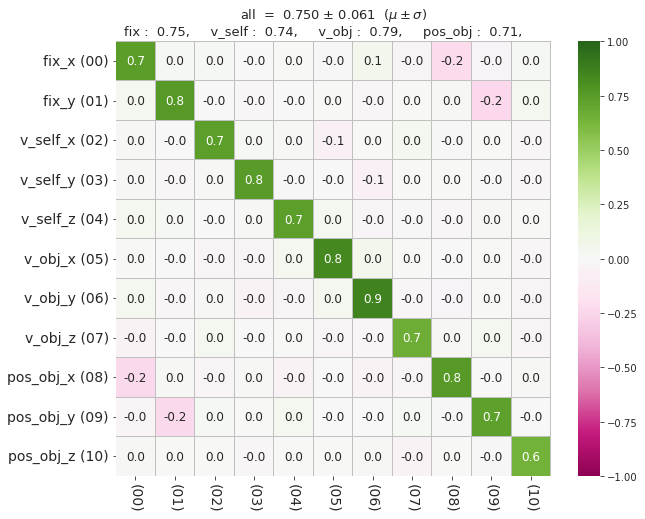

fig/mutual_info

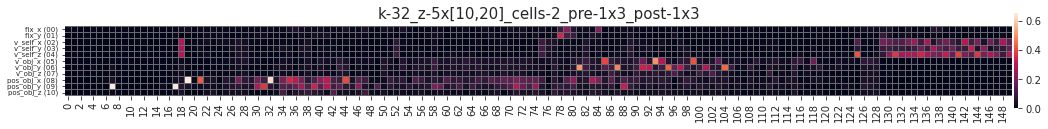

In [17]:
for k, v in val.items():
    if 'fig' in k:
        print(k)
        display(v)

In [16]:
names = tr.dl_tst.dataset.factor_names
_tx = [f"({i:02d})" for i in range(len(names))]
_ty = [f"{e} ({i:02d})" for i, e in names.items()]

In [17]:
fig, _ = show_heatmap(
    r=val['regr/mi'],
    yticklabels=_ty,
    title=f"{tr.model.cfg.name()}",
    tick_labelsize_y=10,
    title_fontsize=20,
    vmin=0,
    vmax=0.65,
    cmap='rocket',
    linecolor='dimgrey',
    cbar_kws={'pad': 0.02},
    figsize=(20, 2.5),
    annot=False,
    display=False,
)

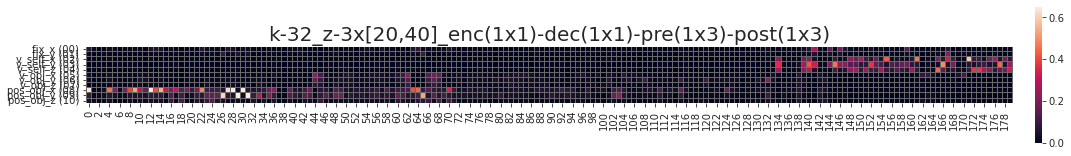

In [18]:
fig

In [19]:
from model.vae2d import *

In [20]:
norms = collections.defaultdict(list)
# norms['stem'] = list(to_np(vae.stem.log_weight_norm.exp()))
for cell in vae.enc_tower:
    for m in cell.modules():
        if hasattr(m, 'log_weight_norm'):
            norms[f"{type(cell).__name__}_enc"].extend(
                list(to_np(m.log_weight_norm.exp())))
for cell in vae.dec_tower:
    for m in cell.modules():
        if hasattr(m, 'log_weight_norm'):
            norms[f"{type(cell).__name__}_dec"].extend(
                list(to_np(m.log_weight_norm.exp())))
for cell in vae.enc_sampler:
    for m in cell.modules():
        if hasattr(m, 'log_weight_norm'):
            norms['enc_sampler'].extend(
                list(to_np(m.log_weight_norm.exp())))
for cell in vae.dec_sampler:
    for m in cell.modules():
        if hasattr(m, 'log_weight_norm'):
            norms['dec_sampler'].extend(
                list(to_np(m.log_weight_norm.exp())))
for cell in vae.expand:
    for m in cell.modules():
        if hasattr(m, 'log_weight_norm'):
            norms['expand'].extend(
                list(to_np(m.log_weight_norm.exp())))
for cell in vae.post:
    for m in cell.modules():
        if hasattr(m, 'log_weight_norm'):
            norms[f"{type(cell).__name__}_post"].extend(
                list(to_np(m.log_weight_norm.exp())))
norms = dict(sorted(norms.items()))

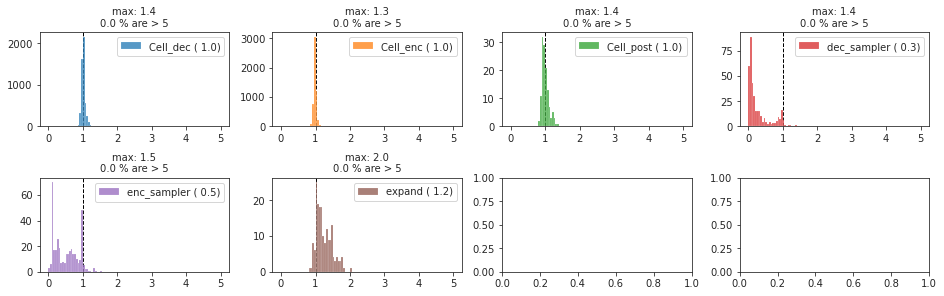

In [21]:
fig, axes = create_figure(2, 4, (13, 4), constrained_layout=True)
for i, (k, v) in enumerate(norms.items()):
    ax = axes.flat[i]
    ax.axvline(1, color='k', ls='--', lw=1.0, zorder=0)
    sns.histplot(v, color=f"C{i}", bins=np.linspace(0, 5, 101), label=f"{k} ({np.mean(v): 0.1f})", ax=ax)
    title = f"max: {np.max(v):0.1f}\n{100 * (np.array(v) > 5).sum() / len(v):0.1f} % are > 5"
    ax.set_title(title, fontsize=10)
    ax.set_ylabel('')
    ax.legend()
plt.show()